# Models 

In [1]:
%matplotlib inline 

import copy
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from conf import settings
from optparse import OptionParser
from util.logging import logg_result
from util.data_preparation import get_data, DataSets
from util.ml_models import regression_map
from util.regression import get_regressor_conf
from numpy.random import choice
from util.logging import logg_result, results_as_dict

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:

with open("runtime.json") as file:
    variables = json.load(file)

def prediction_2017(temporal_validation, res):
    year_2017 = temporal_validation.copy()
    year_2017["forecast"] = res.prediction("validate", apply_inverse=True)
    year_2017["x"] = year_2017.apply(lambda x: x["year"] + x["month"] / 13, 1)
    year_2017.groupby("x").sum()[["value", "forecast"]].plot()
    plt.title("Validation Data: Insured Employment")
    plt.xlabel("Months")


def get_random_config(model_key):
    return {
        "rf": {
            "n_estimators": choice(range(5, 1001, 1)),
            "max_depth": None,
            "max_features": float(choice(range(1, 100, 1)) / 100),
            "min_samples_split": choice(range(2, 6, 1)),
            "min_samples_leaf": 1,
            "criterion": "mse",
            "n_jobs": -1
        },
        "gb": {
            "n_estimators": choice(range(50, 1001, 1)),
            "max_depth": choice(range(3, 60, 1)),
            "max_features": float(choice(range(1, 100, 1)) / 100),
            "min_samples_split": choice(range(2, 6, 1)),
            "min_samples_leaf": 1,
            "loss": choice(["ls", "lad", "huber"]),
            "learning_rate": choice(range(5, 31, 1)) / 100.0
        }
    }.get(model_key)


def get_percentage_error(res):
    return results_as_dict(res).get("model-performance").get("test").get("percentage-error")


def optimize_hyperparameters(model_key, loops, datasets, temporal_validation, speak=True):
    if speak:
        print("> Selected model: {}".format(model_key))
    best_config = get_random_config(model_key)
    best_model = regression_map[model_key].get("function")(best_config,
                                                           copy.deepcopy(datasets),
                                                           copy.deepcopy(temporal_validation))

    for i in range(loops):
        reg_conf = get_random_config(model_key)
        temp_model = regression_map[model_key].get("function")(
            reg_conf,
            copy.deepcopy(datasets),
            copy.deepcopy(temporal_validation))

        error = get_percentage_error(temp_model)
        if speak:
            print("\t* hyperparams optim loop ({}): {}".format(i+1, error))
        if get_percentage_error(best_model) > error:
            best_model = copy.deepcopy(temp_model)
            best_config = reg_conf
    return best_model, best_config



## Create data

In [3]:
ignore = get_data(min_lag=0, save=True, read=False)

/home/rhdzmota/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Train 12 models 

In [10]:
    model_periods = {}
    model_results = {}
    model_performance_validate = []
    production_model = {}
    
    model_key = variables.get("model")
    
    for p in range(1, 13):
        data, temporal_validation, lags = get_data(min_lag=p - 1, save=False, read=True)
        test_cols = [c for c in data.columns if ("t-" in c) or ("value" in c) or ("year" in c) or ("month" in c)]
        datasets = DataSets(data,  # [test_cols],
                            encode_string=False,
                            one_hot_encode=False,
                            categ_to_num=True,
                            link=variables.get("link"),
                            transformations=variables.get("transformations"))
        
        print("------------ Delta: " + str(p))
        res, reg_conf = optimize_hyperparameters(model_key, 20, datasets, temporal_validation)  # [test_cols])
        model_periods[p] = copy.deepcopy(res)
        model_results[p] = {
            "config": reg_conf,
            "general": results_as_dict(model_periods[p])
        }
        model_performance_validate.append(
            model_results[p].get("general").get("model-performance").get("validate").get("percentage-error"))
        del data
        del datasets
        del res

------------ Delta: 1
> Selected model: rf
	* hyperparams optim loop (1): 0.8880383576998607
	* hyperparams optim loop (2): 0.8039461680504103
	* hyperparams optim loop (3): 0.9044606164378761
	* hyperparams optim loop (4): 0.814674858539084
	* hyperparams optim loop (5): 0.8395801174522387
	* hyperparams optim loop (6): 1.2225781757802694
	* hyperparams optim loop (7): 6.195249122071074
	* hyperparams optim loop (8): 1.2338303825061347
	* hyperparams optim loop (9): 1.2260273477353898
	* hyperparams optim loop (10): 4.868965002688529
	* hyperparams optim loop (11): 0.8160114905726249
	* hyperparams optim loop (12): 0.7934531498903664
	* hyperparams optim loop (13): 4.896987628928059
	* hyperparams optim loop (14): 2.013435913365129
	* hyperparams optim loop (15): 0.9153087036776969
	* hyperparams optim loop (16): 1.2122495895943455
	* hyperparams optim loop (17): 1.223752740137168
	* hyperparams optim loop (18): 2.2970375659800277
	* hyperparams optim loop (19): 2.4193259929386857
	* 

	* hyperparams optim loop (19): 5.816847326391511
	* hyperparams optim loop (20): 7.364228507165439
------------ Delta: 9
> Selected model: rf
	* hyperparams optim loop (1): 19.936128653368687
	* hyperparams optim loop (2): 15.34162615323001
	* hyperparams optim loop (3): 8.083133341050111
	* hyperparams optim loop (4): 7.457555126395056
	* hyperparams optim loop (5): 5.762268682899122
	* hyperparams optim loop (6): 7.471743879753381
	* hyperparams optim loop (7): 14.994669664455257
	* hyperparams optim loop (8): 7.206063876665372
	* hyperparams optim loop (9): 7.657548031930984
	* hyperparams optim loop (10): 19.099754450891787
	* hyperparams optim loop (11): 5.789370676537958
	* hyperparams optim loop (12): 12.218320170609507
	* hyperparams optim loop (13): 10.36350868954859
	* hyperparams optim loop (14): 11.395426998574013
	* hyperparams optim loop (15): 14.093527727452061
	* hyperparams optim loop (16): 5.727422630983062
	* hyperparams optim loop (17): 7.9777722320090305
	* hyperp

In [11]:
model_results

{1: {'config': {'criterion': 'mse',
   'max_depth': None,
   'max_features': 0.74,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 431,
   'n_jobs': -1},
  'general': {'model-desc': {'lags': ['t-7', 't-1']},
   'model-performance': {'test': {'ame': 118.31160821150368,
     'percentage-error': 0.7934531498903449,
     'rsme': 298.7489028463085},
    'train': {'ame': 24.46790016018369,
     'percentage-error': 0.024738510682956526,
     'rsme': 65.84239628413471},
    'validate': {'ame': 214.80360570704715,
     'percentage-error': 2.020933990892803,
     'rsme': 682.5856024281965}},
   'validation-data-2017': {'age_range': {'De 15 a 19 años.': {'abs_error': 17945.388886759243,
      'percentage_error': 4.070449086297376,
      'prediction': 428796.52037576516,
      'value': 440870.0},
     'De 20 a 24 años.': {'abs_error': 39051.923554469045,
      'percentage_error': 2.2143814612649217,
      'prediction': 1736285.9853702704,
      'value': 1763559.0},
     'De

In [3]:
    class GeneralJsonEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.int64):
                return str(obj)
            return json.JSONEncoder.default(self, obj)



In [ ]:
    with open("model_results_training.json", "w") as file:
        file.write(json.dumps(model_results, cls=GeneralJsonEncoder))

## Model performance 

In [13]:
    def get_values_for(category, variable, model_results):
        core = []
        for p in range(1, 13):
            temp = model_results[p].get("general")["validation-data-2017"].get(category)
            row = {}
            for k in temp:
                if "Menor" in k:  # ignore menores
                    continue
                row[k] = temp[k].get(variable)
            core.append(row)
        return pd.DataFrame(core)

In [14]:
    model_performance_test = []
    model_performance_train = []
    for i in range(1, 13):
        model_performance_test.append(
            model_results[i].get("general").get("model-performance").get("test").get("percentage-error"))
        model_performance_train.append(
            model_results[i].get("general").get("model-performance").get("train").get("percentage-error"))


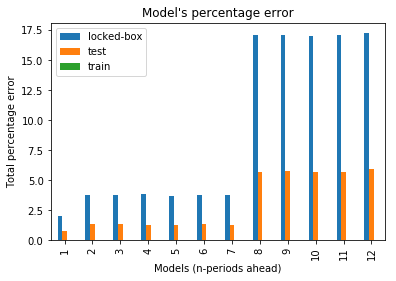

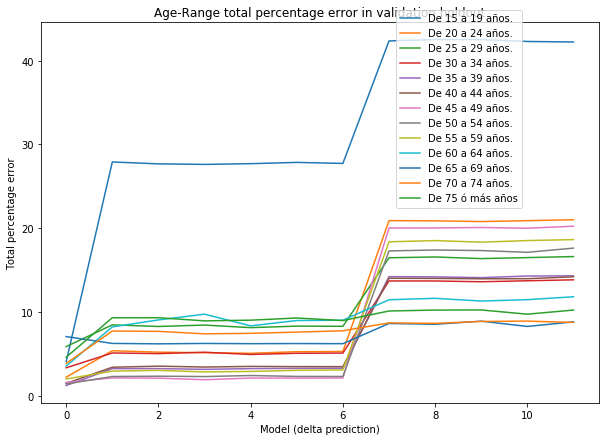

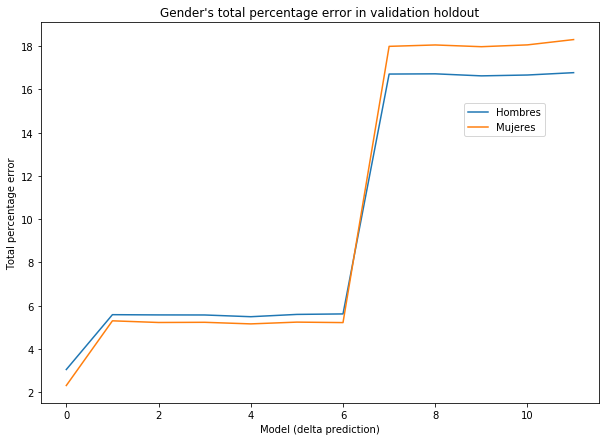

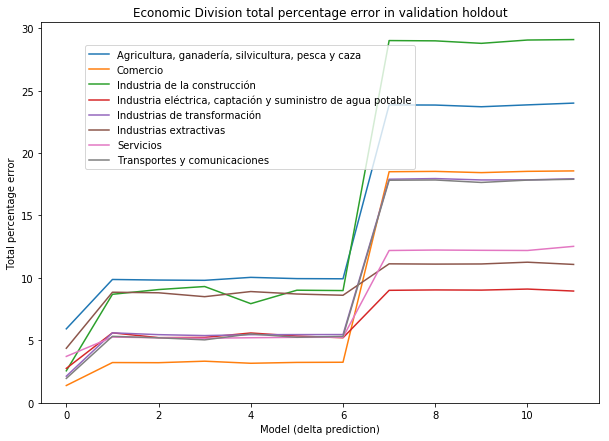

In [16]:
    pd.DataFrame({
        "test": model_performance_test,
        "train": model_performance_train,
        "locked-box": model_performance_validate
    }, index=range(1, 13)).plot.bar()
    # plt.plot(range(1, 13), model_performance_validate)
    plt.title("Model's percentage error")
    plt.xlabel("Models (n-periods ahead)")
    plt.ylabel("Total percentage error")
    plt.show()

    error_type = "percentage_error"
    df = get_values_for("age_range", error_type, model_results)
    df.plot(figsize=(10, 7)).legend(bbox_to_anchor=(0.75, 0.5))
    plt.title("Age-Range total percentage error in validation holdout")
    plt.ylabel("Total percentage error")
    plt.xlabel("Model (delta prediction)")
    plt.show()
    df = get_values_for("gender", error_type, model_results)
    df.plot(figsize=(10, 7)).legend(bbox_to_anchor=(0.75, 0.80))
    plt.title("Gender's total percentage error in validation holdout")
    plt.ylabel("Total percentage error")
    plt.xlabel("Model (delta prediction)")
    plt.show()
    df = get_values_for("economic_division", error_type, model_results)
    df.plot(figsize=(10, 7)).legend(bbox_to_anchor=(0.68, 0.60))
    plt.title("Economic Division total percentage error in validation holdout")
    plt.ylabel("Total percentage error")
    plt.xlabel("Model (delta prediction)")
    plt.show()


## Production model - training

In [4]:
    model_periods = {}
    model_results = {}
    model_performance_validate = []
    production_model = {}
    with open("model_results_training.json") as file:
        model_results_training = json.load(file)
    for p in range(1, 13):
        data, temporal_validation, lags = get_data(min_lag=p - 1, save=False, read=True)
        comp_data = pd.concat([data, temporal_validation])

        dts = DataSets(comp_data,
                               encode_string=False,
                               one_hot_encode=False,
                               categ_to_num=True,
                               link=variables.get("link"),
                               transformations=variables.get("transformations"),
                               shuffle=True)
        reg_conf = {}# model_results_training[str(p)].get("config")
        for k in model_results_training[str(p)].get("config"):
            try:
                reg_conf[k] = int(model_results_training[str(p)].get("config")[k]) if k != "max_features" else float(model_results_training[str(p)].get("config")[k])
            except:
                reg_conf[k] = model_results_training[str(p)].get("config")[k]
        pres = regression_map[variables.get("model")].get("function")(reg_conf, dts, temporal_validation)
        model_periods[p] = copy.deepcopy(pres)
        model_results[p] = {
            "config": reg_conf,
            "general": results_as_dict(model_periods[p]),
            "model": pickle.dumps(pres.model).hex(),
            "cols": list(dts.get_train(False).columns)
        }
        del data
        del dts
        del pres

In [5]:
production_model = model_results
model_results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [ ]:
    with open("production_model.json", "w") as file:
        file.write(json.dumps(model_results, cls=GeneralJsonEncoder))

## Create prediction

In [19]:
    with open("production_model.json") as file:
        production_model = json.load(file)
        
    production_model

{'1': {'config': {'criterion': 'mse',
   'max_depth': None,
   'max_features': 0.74,
   'min_samples_leaf': 1,
   'min_samples_split': '2',
   'n_estimators': '431',
   'n_jobs': -1},
  'general': {'model-desc': {'lags': ['t-7', 't-1']},
   'model-performance': {'test': {'ame': 118.31160821150368,
     'percentage-error': 0.7934531498903449,
     'rsme': 298.7489028463085},
    'train': {'ame': 24.46790016018369,
     'percentage-error': 0.024738510682956526,
     'rsme': 65.84239628413471},
    'validate': {'ame': 214.80360570704715,
     'percentage-error': 2.020933990892803,
     'rsme': 682.5856024281965}},
   'validation-data-2017': {'age_range': {'De 15 a 19 años.': {'abs_error': 17945.388886759243,
      'percentage_error': 4.070449086297376,
      'prediction': 428796.52037576516,
      'value': 440870.0},
     'De 20 a 24 años.': {'abs_error': 39051.923554469045,
      'percentage_error': 2.2143814612649217,
      'prediction': 1736285.9853702704,
      'value': 1763559.0},
  

In [10]:
    def create_prediction_df(year, month, delta):
        cat_cols = ["economic_division", "age_range", "gender"]
        a, b, c = get_data(min_lag=0, save=False, read=True)
        complete_data = pd.concat([a, b])
        complete_data["time"] = complete_data.year + (complete_data.month-1) / 12
        complete_data = complete_data[[c for c in complete_data.columns if "t-" not in c]]
        req_lags = production_model[str(delta)].get("general")["model-desc"].get("lags")

        def add_lags(sub_df, lags):
            original_index = sub_df.index
            response = sub_df.reset_index(drop=True)[["value"]]
            for lag in lags:
                temp = response[["value"]].iloc[:-lag]
                temp.index = temp.index + lag
                response["t-{}".format(lag)] = temp
            response.index = original_index
            del response["value"]
            return pd.concat([sub_df, response], axis=1)

        def add_lags_recursive(df, cols, lags, result_df=pd.DataFrame([])):
            unique_vals = df[cols[0]].unique()
            # sub_df = df.query("{} == '{}'".format("economic_division", "Servicios")).query("{} == '{}'".format("gender", "Mujeres")).query("{} == '{}'".format("age_range", "De 25 a 29 años."))
            for val in unique_vals:
                sub_df = df.query("{} == '{}'".format(cols[0], val))
                if len(cols) == 1:
                    max_time = sub_df.time.max()
                    if year + (month-1) / 12 > max_time:
                        for i in range(int(12 * (year + (month-1) / 12 - max_time))):
                            last = sub_df.iloc[-1]
                            row = {}
                            row["year"] = last.year + 1 if last.month == 12 else last.year
                            row["month"] = 1 if last.month == 12 else last.month + 1
                            row["time"] = row["year"] + (row["month"] - 1) / 12
                            row["value"] = float("nan")
                            for c in cat_cols:
                                row[c] = last[c]
                            sub_df = sub_df.append(pd.DataFrame([row], index=[sub_df.index.max() + 1]))

                    #result_df = pd.concat([result_df, add_lags(sub_df, lags)], axis=0)
                #else:
                    #result_df = add_lags_recursive(sub_df, cols[1:], lags, result_df=result_df)

                result_df = pd.concat([result_df, add_lags(sub_df, lags)], axis=0) \
                    if len(cols) == 1 else add_lags_recursive(sub_df, cols[1:], lags, result_df=result_df)
            return result_df

        dff = add_lags_recursive(complete_data.copy(), cat_cols, [int(a.replace("t-", "")) for a in req_lags])
        dff = dff.query("year == {} & month == {}".format(year, month))
        dff["value"] = 0
        return dff.dropna()

In [11]:
prpediction_df = create_prediction_df(2018, 2, 1)

prpediction_df.head()

/home/rhdzmota/.local/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/rhdzmota/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/rhdzmota/.local/lib/python3.5/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

,age_range,economic_division,gender,month,t-1,t-2,t-3,t-6,t-7,time,value,year
2907,De 75 ó más años,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,2,215.0,208.0,204.0,182.0,142.0,2018.083333,0,2018.0
2981,De 75 ó más años,"Agricultura, ganadería, silvicultura, pesca y ...",Hombres,2,540.0,523.0,499.0,467.0,392.0,2018.083333,0,2018.0
2914,Menor a 15 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Hombres,2,5.0,3.0,3.0,2.0,4.0,2018.083333,0,2018.0
2925,Menor a 15 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,2,6.0,2.0,2.0,4.0,4.0,2018.083333,0,2018.0
2901,De 40 a 44 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,2,2848.0,2856.0,2907.0,2664.0,2314.0,2018.083333,0,2018.0


In [18]:
prpediction_df.month.unique()

array([2])

In [20]:
production_model[str(1)].get("config")

{'criterion': 'mse',
 'max_depth': None,
 'max_features': 0.74,
 'min_samples_leaf': 1,
 'min_samples_split': '2',
 'n_estimators': '431',
 'n_jobs': -1}

In [60]:
production_model[str(1)]

In [45]:
    year  = 2018
    month = 2
    prediction = pd.DataFrame([])
    for p in range(1, 3):
        if month < 12:
            month += 1
        else:
            month = 1
            year += 1
        model_index = p
        data = create_prediction_df(year, month, p)
        model = pickle.loads(bytes.fromhex(production_model[model_index]["model"]))
        cols = production_model[model_index]["cols"]
        dts = DataSets(data,
                            encode_string=False,
                            one_hot_encode=False,
                            categ_to_num=True,
                            link=variables.get("link"),
                            transformations=variables.get("transformations"),
                            shuffle=True)
        res = model.predict(dts.external(data[cols])[cols])
        data["value"] = dts.inverse_function[dts.link](res)
        prediction = pd.concat([prediction, data])
        del data
        del dts
        del model

/home/rhdzmota/.local/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/rhdzmota/.local/lib/python3.5/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/c/Users/rhdzm/Documents/Github/rhdzmota/iieg-employment-forecast/util/data_preparation.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [49]:
training_data, temporal_validation, lags = get_data()
database_df = pd.concat([training_data, temporal_validation])

In [52]:
database_df.month.max()

12

In [47]:
prediction.month.unique()

array([3, 4])

In [11]:
data = create_prediction_df(2018, 3, 1)

/home/rhdzmota/.local/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/rhdzmota/.local/lib/python3.5/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
model = pickle.loads(bytes.fromhex(production_model[1]["model"]))

In [14]:
cols = production_model[1]["cols"]
cols

['economic_division',
 'gender',
 'age_range',
 'year',
 'month',
 't-7',
 't-2',
 't-6',
 't-1',
 't-3']

In [38]:
        dts = DataSets(data,
                            encode_string=False,
                            one_hot_encode=False,
                            categ_to_num=True,
                            link=variables.get("link"),
                            transformations=variables.get("transformations"),
                            shuffle=True)

In [29]:
variables.get("link")

'root_7'

In [32]:
dts.inverse_function[dts.link](res)

array([1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765192,
       1.08765192, 1.08765192, 1.08765192, 1.08765192, 1.08765

In [39]:
dts.external(data)[cols]

,economic_division,gender,age_range,year,month,t-7,t-2,t-6,t-1,t-3
0,1.000245,1.000245,1.000245,2018.0,3,1.000006,1.000007,1.000006,1.000007,1.000006
1,1.000245,1.000245,1.000245,2018.0,3,1.000007,1.000008,1.000007,1.000008,1.000008
2,1.000245,1.000245,1.000245,2018.0,3,1.000001,1.000002,1.000001,1.000001,1.000001
3,1.000245,1.000245,1.000245,2018.0,3,1.000002,1.000002,1.000001,1.000002,1.000001
4,1.000245,1.000245,1.000245,2018.0,3,1.000010,1.000010,1.000010,1.000010,1.000010
5,1.000245,1.000245,1.000245,2018.0,3,1.000011,1.000011,1.000011,1.000011,1.000011
6,1.000245,1.000245,1.000245,2018.0,3,1.000011,1.000011,1.000011,1.000011,1.000011
7,1.000245,1.000245,1.000245,2018.0,3,1.000010,1.000010,1.000010,1.000010,1.000010
8,1.000245,1.000245,1.000245,2018.0,3,1.000009,1.000009,1.000009,1.000009,1.000009
9,1.000245,1.000245,1.000245,2018.0,3,1.000010,1.000010,1.000010,1.000010,1.000010


In [40]:
res = model.predict(dts.external(data)[cols])
data["value"] = res

In [42]:
data

,age_range,economic_division,gender,month,time,value,year,t-7,t-2,t-6,t-1,t-3
26881,De 75 ó más años,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,3,2018.166667,1.012075,2018.0,1.000001,1.000001,1.000001,1.000001,1.000001
26841,De 75 ó más años,"Agricultura, ganadería, silvicultura, pesca y ...",Hombres,3,2018.166667,1.012075,2018.0,1.000001,1.000001,1.000001,1.000001,1.000001
26973,Menor a 15 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Hombres,3,2018.166667,1.012075,2018.0,1.000000,1.000000,1.000000,1.000000,1.000000
26777,Menor a 15 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,3,2018.166667,1.012075,2018.0,1.000000,1.000000,1.000000,1.000000,1.000000
26974,De 40 a 44 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,3,2018.166667,1.012075,2018.0,1.000001,1.000001,1.000001,1.000001,1.000001
26795,De 40 a 44 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Hombres,3,2018.166667,1.012075,2018.0,1.000002,1.000002,1.000002,1.000002,1.000002
26948,De 30 a 34 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Hombres,3,2018.166667,1.012075,2018.0,1.000002,1.000002,1.000002,1.000002,1.000002
26941,De 30 a 34 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,3,2018.166667,1.012075,2018.0,1.000001,1.000001,1.000001,1.000001,1.000001
26880,De 50 a 54 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,3,2018.166667,1.012075,2018.0,1.000001,1.000001,1.000001,1.000001,1.000001
26879,De 50 a 54 años.,"Agricultura, ganadería, silvicultura, pesca y ...",Hombres,3,2018.166667,1.012075,2018.0,1.000001,1.000001,1.000001,1.000001,1.000001


## Test Lib

In [1]:
from util.serving import prediction_precedure, production_model_procedure

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [ ]:
production_model_procedure()

In [2]:
prediction_precedure()

Expecting value: line 1 column 1 (char 0)


False